# MIDAS@IIITD Internship Task
## Speech Emotion Problem

### Problem Statement : 
Dataset contains two folders train and valid. Individual folder contains speech utterances/.wav files of 5 categories on which to do classification. The classes are namely : ***disgust, fear, happy, neutral, sad.*** 
The data is in .wav format.

### Importing Necessary libraries

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms
import torchvision
from torch import optim

Using TensorFlow backend.


### Loading audio files using *Librosa* library.
**LibROSA is a python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems.** [Librosa Documentation Link](https://librosa.github.io/librosa/)

Here we used *librosa.load()* function to load the .wav audio files and this function returns the audio data and the sample rate at which the audio was sampled.

In [2]:
audio, sr = librosa.load(r'emotion\meld\train\happy\MEL_dia125_utt11_positive_HAP.wav')
#function returns audio and sampling rate (22050 in the given dataset)

Here we plotted an audio file using the *librosa.display.waveplot()* function. 

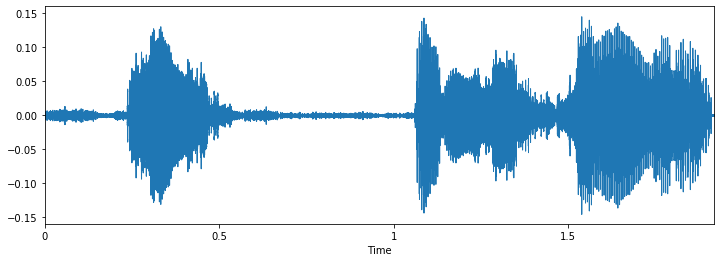

In [3]:
plt.figure(figsize=(12, 4))
librosa.display.waveplot(audio, sr=sr)

### Loading Data
Here we defined load_dataset() function to load train and validation data from the given dataset.

In [2]:
# define function to load train and validation datasets
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    
    return files, targets

# load train and validation datasets
train_audio, train_labels = load_dataset(r'emotion\meld\train')
valid_audio, valid_labels = load_dataset(r'emotion\meld\val')

# load list of classes
classes = [item[20:-1] for item in sorted(glob("emotion/meld/train/*/"))]

# print statistics about the dataset
print('There are %d total classes.' % len(classes))
print('There are %s total audio files.' % len(np.hstack([train_audio, valid_audio])))
print('There are %d training audio files.' % len(train_audio))
print('There are %d validation audio files.' % len(valid_audio))

There are 5 total classes.
There are 6239 total audio files.
There are 5409 training audio files.
There are 830 validation audio files.


### Extracting features from audio files.
Working on audio files starts with extracting one or various features from the audio files and getting those features in *numpy ndarray* makes it easy to work on it.

Here we extracted **melspectrogram** feature from the audio files and plotted the same with time and frequency at X-axis and Y-axis respectively. [ibrosa.feature.melspectrogram](https://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html)

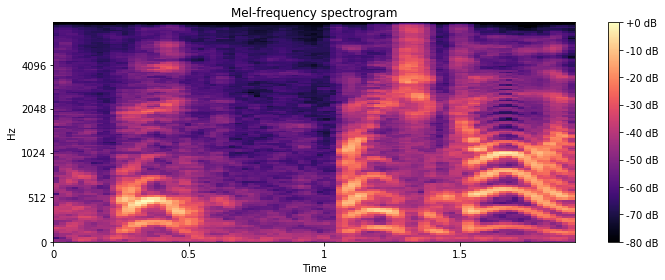

In [5]:
S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

### Fixing audio length
Here we came across a fact, that the length of all audio files is different and extracting a same feature from different audio files will give different shape of ndarray, which is not possible to list-up. That's why we used a function namely : [*librosa.util.fix_length*](https://librosa.github.io/librosa/generated/librosa.util.fix_length.html)
This function takes input as audio file and the desired length of the array.

Here we gave 66150 as the length of the desired audio file which corresponds to 3.0 seconds. As the audio files are sampled at 22050 Hz, to get 3 seconds of the data, desired length should be given as *3 X 22050 = 66150*. If the audio file is already under 3 seconds, it will pad it with zeros to make it upto 3 seconds and if the data file is more than 3 seconds, it will compress the file by sampling it with more sampling rate to get the whole data in exact 3 seconds. 

Plotting a fixed length file. A straight line seen at the end of the plot is the **padding of zeros.**

shape before fixing length (42336,)
time before fixing length 1.92
shape after fixing length (66150,)
time after fixing length 3.0


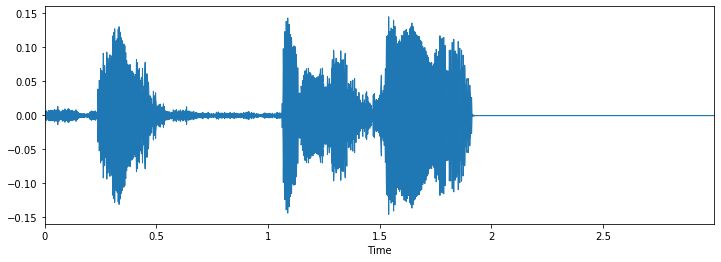

In [6]:
y, sr = librosa.load(r'emotion\meld\train\happy\MEL_dia125_utt11_positive_HAP.wav')
z = librosa.core.get_duration(y)
print('shape before fixing length', y.shape)
print('time before fixing length', z)
z = librosa.util.fix_length(y, 66150)
p = librosa.core.get_duration(z)
print('shape after fixing length', z.shape)
print('time after fixing length', p)
plt.figure(figsize=(12, 4))
librosa.display.waveplot(z, sr=sr)

This is a melspectrogram of a fixed length file, where the empty black portion corresponds to zeros that are padded to make the file upto 3 seconds long.


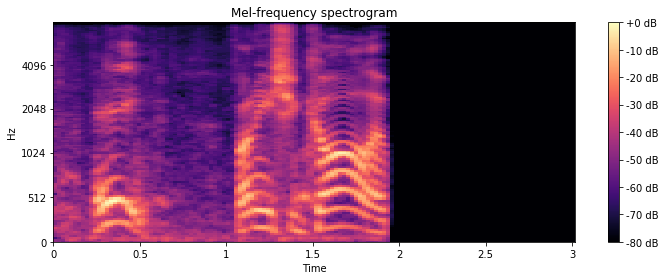

In [7]:
S = librosa.feature.melspectrogram(y=z, sr=sr, n_mels=128, fmax=8000)
plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

### Making a list of all audio files with fixed length and melspectrogram feature to pass it in the network.
Here signal_direct is the list which contains melspectrogram features of all fixed length files from the training data and the signal_direct_val contains the files from the validation data. 
The approach taken here is to make a list for melspectrogram feature for each audio file and check whether it can differentiate between different emotions as required.

In [ ]:
signal_direct = []
for i in tqdm(train_audio):
    d = librosa.core.load(i)[0]
    d = librosa.util.fix_length(d, 66150)
    d = librosa.feature.melspectrogram(d, n_fft=512, hop_length=128)
    d = librosa.power_to_db(d, ref=np.max)
    signal_direct.append(d)
    

signal_direct_val = []
for i in tqdm(valid_audio):
    e = librosa.core.load(i)[0]
    e = librosa.util.fix_length(e, 66150)
    e = librosa.feature.melspectrogram(e, n_fft=512, hop_length=128)
    e = librosa.power_to_db(e, ref=np.max)
    signal_direct_val.append(e)

Here we saved all the data variables in a **pickle** file, so that we don't have to load the audio files again into the list, once we dump the variables into the pickle file.

In [ ]:
with open('train1.pickle', 'wb') as file:
    pickle.dump([signal_direct, train_labels, signal_direct_val, valid_labels], file)

Loading data variables from the pickle file.

In [ ]:
with open('train1.pickle', 'rb') as file:
    signal_direct, train_labels, signal_direct_val, valid_labels = pickle.load(file)

### Applying  Short Term Fourier Transform (STFT) to the audio signal and passing it in the melspectrogram feature.
The melspectrogram feature alone didn't do well in the network, that's why we proceeded with STFT followed by a melspectrogram to make it feature rich and so that the model can see the differences in the features.

Here we are converting the audio file to STFT that represents the audio in time-frequency domain and passing the same in the melspectrogram to finally plot it.
STFT applies Fourier Transform on the input signal. [*librosa.core.stft*](https://librosa.github.io/librosa/generated/librosa.core.stft.html)

shape after Short-time Fourier transform (257, 517)


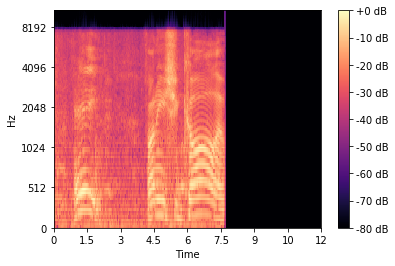

In [8]:
z = librosa.core.stft(z, n_fft=512)
z = np.abs(z)
print('shape after Short-time Fourier transform', z.shape)

q = librosa.feature.melspectrogram(S = z)
j = librosa.power_to_db(q, ref=np.max)
librosa.display.specshow(j, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

### Making a list of all STFT converted audio files with fixed length and melspectrogram feature to pass it in the network.
Here signal_stft is the list which contains melspectrogram features of all fixed length & stft applied audio files from the training data and the signal_stft_val contains the files from the validation data. 
The approach taken here is to make a list for melspectrogram feature for each audio file with stft conversion and check whether these **2 features combined** can differentiate between different emotions as required.

In [ ]:
signal_stft = []
for i in tqdm(train_audio):
    d = librosa.core.load(i)[0]
    d = librosa.util.fix_length(d, 66150)
    d = librosa.core.stft(d, n_fft=512)
    d = np.abs(d)
    d = librosa.feature.melspectrogram(S = d)
    d = librosa.power_to_db(d, ref=np.max)
    signal_stft.append(d)
    
signal_stft_val = []
for i in tqdm(valid_audio):
    e = librosa.core.load(i)[0]
    e = librosa.util.fix_length(e, 66150)
    e = librosa.core.stft(e, n_fft=512)
    e = np.abs(e)
    e = librosa.feature.melspectrogram(S = e)
    e = librosa.power_to_db(e, ref=np.max)
    signal_stft_val.append(e)

In [ ]:
with open('train.pickle', 'wb') as f:
    pickle.dump([signal_stft, train_labels, signal_stft_val, valid_labels], f)

In [ ]:
with open('train.pickle', 'rb') as f:
    signal_stft, train_labels, signal_stft_val, valid_labels = pickle.load(f)

### Extracting MFCC feature from the librosa library for better understanding of the audio feature to pass it into the network.
Extracting MFCC feature from the audio signals and plotting the same.
[*librosa.feature.mfcc*](https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html)

Help taken from [this](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/) link.

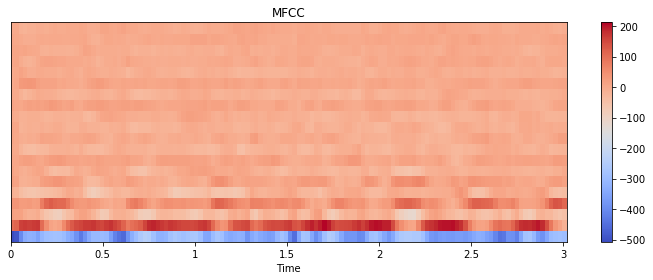

In [12]:
mfcc = librosa.feature.mfcc(y)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

### Making a list of all audio files with fixed length and MFCC feature to pass it in the network.
Here mfccs is the list which contains mfcc features of all fixed length files from the training data and the mfccs_val contains the files from the validation data. 
The approach taken here is to make a list for mfcc feature for each audio file and check whether it can differentiate between different emotions as required, because the **approaches taken above didn't lead us to the desired results.**

In [ ]:
mfccs = []
for i in tqdm(train_audio):
    y = librosa.core.load(i)[0]
    y = librosa.util.fix_length(y, 66150)
    mfcc = librosa.feature.mfcc(y=y, sr=22050, n_mfcc=40)
    mfccs.append(mfcc) 

mfccs_val = []
for i in tqdm(valid_audio):
    y = librosa.core.load(i)[0]
    y = librosa.util.fix_length(y, 66150)
    mfcc = librosa.feature.mfcc(y=y, sr=22050, n_mfcc=40)
    mfccs_val.append(mfcc)       

In [ ]:
with open('train2.pickle', 'wb') as f:
    pickle.dump([mfccs, train_labels, mfccs_val, valid_labels], f)

In [ ]:
with open('train2.pickle', 'rb') as f:
    mfccs, train_labels, mfccs_val, valid_labels = pickle.load(f)

### Applying  Short Term Fourier Transform (STFT) to the audio signal and passing it in the amplitude_to_db function().
Extracting [*librosa.amplitude_to_db*](https://librosa.github.io/librosa/master/generated/librosa.core.amplitude_to_db.html) feature from the audio signals and plotting the same.

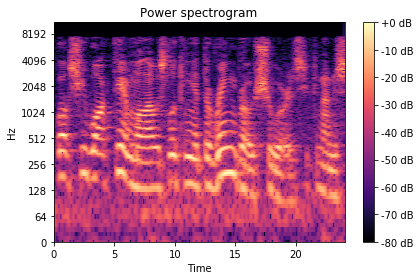

In [13]:
D_short = np.abs(librosa.stft(y, hop_length=64))
librosa.display.specshow(librosa.amplitude_to_db(D_short, ref=np.max), y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

(66150,)
(257, 662)


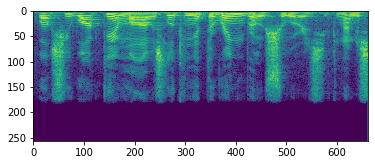

In [11]:
y = librosa.core.load(r'emotion\meld\train\fear\MEL_dia723_utt7_negative_FEA.wav')[0]
y = librosa.util.fix_length(y, 66150)
print(y.shape)
D_short = np.abs(librosa.stft(y,n_fft = 512, hop_length=100))
print(D_short.shape)
D_short = librosa.amplitude_to_db(D_short, ref=np.max)
plt.imshow(D_short)

### Making a list of all stft converted audio files with fixed length and audio_to_db conversion.
Here final is the list which contains stft and audio_to_db converted files of fixed length from the training data and the final_val contains the files from the validation data. 
The approach taken here is to make a list for mfcc feature for each audio file and check whether it can differentiate between different emotions as required, because the **approaches taken above didn't lead us to the desired results.**

In [14]:
final = []
for y in tqdm(train_audio):
    y = librosa.core.load(y)[0]
    y = librosa.util.fix_length(y, 66150)
    D_short = np.abs(librosa.stft(y,n_fft = 512, hop_length=100))
    D_short = librosa.amplitude_to_db(D_short, ref=np.max)
    final.append(D_short)

final_val = []
for y in tqdm(valid_audio):
    y = librosa.core.load(y)[0]
    y = librosa.util.fix_length(y, 66150)
    D_short = np.abs(librosa.stft(y,n_fft = 512, hop_length=100))
    D_short = librosa.amplitude_to_db(D_short, ref=np.max)
    final_val.append(D_short)

In [15]:
with open('FINAL.pickle', 'wb') as f:
    pickle.dump([final, train_labels, final_val, valid_labels], f)

In [3]:
with open('FINAL.pickle', 'rb') as f:
    final, train_labels, final_val, valid_labels = pickle.load(f)

### Chroma STFT
In speech and music, the term chroma feature or chromagram closely relates to the twelve different pitch classes. Chroma-based features, which are also referred to as "pitch class profiles", are a powerful tool for analyzing music whose pitches can be meaningfully categorized (often into twelve categories) and whose tuning approximates to the equal-tempered scale. One main property of chroma features is that they capture harmonic and melodic characteristics of music, while being robust to changes in timbre and instrumentation.

## This is final audio feature which we will be passing into our neural network

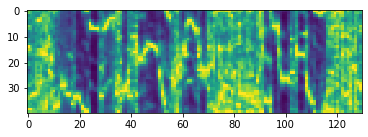

In [4]:
y = librosa.core.load(r'emotion\meld\train\happy\MEL_dia112_utt11_positive_HAP.wav')[0]
y = librosa.util.fix_length(y, 66150)
S = np.abs(librosa.stft(y))
D_short = librosa.feature.chroma_stft(S=S, n_chroma=40)
plt.imshow(D_short)

In [ ]:
chromaa = []
for y in tqdm(train_audio):
    y = librosa.core.load(y)[0]
    y = librosa.util.fix_length(y, 66150)
    S = np.abs(librosa.stft(y))
    chroma = librosa.feature.chroma_stft(S=S, n_chroma=40)
    chromaa.append(chroma)

chroma_val = []
for y in tqdm(valid_audio):
    y = librosa.core.load(y)[0]
    y = librosa.util.fix_length(y, 66150)
    S = np.abs(librosa.stft(y))
    chroma = librosa.feature.chroma_stft(S=S, n_chroma=40)
    chroma_val.append(chroma)

In [4]:
with open('FINAL1.pickle', 'wb') as f:
    pickle.dump([chromaa, train_labels, chroma_val, valid_labels], f)

In [2]:
with open('FINAL1.pickle', 'rb') as f:
    chromaa, train_labels, chroma_val, valid_labels = pickle.load(f)

### Normalizing
Here we are normalizing the inputs to pass them into the network.

In [3]:
normalized = []
for i in tqdm(chromaa):
    i = (i-i.min())/(i.max()-i.min())
    normalized.append(i)
normalized_val = []
for i in tqdm(chroma_val):
    i = (i-i.min())/(i.max()-i.min())
    normalized_val.append(i)

In [4]:
images = np.asarray(normalized)
images_val = np.asarray(normalized_val)

### Defining Custom Dataset Function
We will make a Dataset Function which will do all the preprocessing to the data and this will help Data_loader by giving the images and labels of the particular index as desired by the Data_loader. Following preprocessing steps are necessary

- We need to convert list into array as the data we have is in a list. So to convert it into a tensor we need to convert it into an array first, then convert it into a tensor.
- We need to reshape the images as they are in shape 256,662. We will convert them into 224x224 with 1 channel.
- We need to convert the pixel values into float as we need to normalize the pixels before feeding to the network because we dont want our network to deal matrix multiplications of large numbers.

For more details on how to define your custom dataset function, go to [this guide](https://github.com/utkuozbulak/pytorch-custom-dataset-examples). It is a great guide.

In [5]:
class MyDataset(Dataset):
    
    def __init__(self, images, labels, transform = None):
        
        self.transform = transform
        self.labels = labels
        self.images = images

    def __getitem__(self, item):
        
        # Applying transformations
        images, labels = self.images[item], self.labels[item]
        if self.transform is not None:
            images = self.transform(images)

        return images, labels

    def __len__(self):
        return len(self.labels)

### Implementing Transformations and Defining training and validation Loader
Now we will convert the data to a PIL Image and then to a tensor. Then we will feed the dataset into our custom dataset function for all the preprocessing.
We are using PyTorch framework to perform the transformations on the input images and using the Data Loader function. This loads the dataset and provides single or multi-process iterators over the dataset

In [6]:
train_transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((40,140)), transforms.ToTensor()])

valid_transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((40,140)), transforms.ToTensor()])

# Feeding the dataset for all the preprocessing
Data = MyDataset(images, train_labels, transform=train_transform)
Data_val = MyDataset(images_val, valid_labels, transform=valid_transform)

# Defining Train and validaion loader 
train_loader = torch.utils.data.DataLoader(Data, batch_size=128, shuffle = True)
validation_loader = torch.utils.data.DataLoader(Data_val, batch_size=32, shuffle = True)

### Defining our own Network Architecture
Here comes the main part of this project. All the cool and magical stuff happens here. We will use [Convolutional neural networks](https://medium.com/technologymadeeasy/the-best-explanation-of-convolutional-neural-networks-on-the-internet-fbb8b1ad5df8) here. CNNs, like neural networks, are made up of neurons with learnable weights and biases. Each neuron receives several inputs, takes a weighted sum over them, pass it through an activation function and responds with an output. The whole network has a loss function and all the tips and tricks that we developed for neural networks still apply on CNNs. Most common layers we will be using are :

- [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
- [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most active pixels from the previous layer.
- The usual Linear + Dropout layers are used to avoid overfitting.

We trained on this network.

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.Convolution1 = nn.Sequential(
            
            # convolutional layer
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            
            # Batch Normalization layer
            nn.BatchNorm2d(64),
            
            # Activation Function
            nn.ReLU(),
            
            nn.Dropout(p=0.2),
            
            # max pooling layer
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            
            nn.BatchNorm2d(128),
            
            nn.ReLU(),
            
            nn.Dropout(p=0.2),
            
            nn.MaxPool2d(kernel_size=2),
            
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            
            nn.BatchNorm2d(256),
            
            nn.ReLU()
        
          
            )
                
        #Fully Connected 1
        
        self.fc = nn.Linear(10*35*256, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 5)


    def forward(self, x):
        
        output = self.Convolution1(x)
                
        output = output.view(output.size(0), -1)
        
        output = self.fc(output)
        output = self.fc2(output)
        output = self.fc3(output)

        return output

# We will train model on GPU. So we need to move the model first to the GPU.
model = CNN()
if torch.cuda.is_available():
    model.cuda()
print(model)

CNN(
  (Convolution1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
  )
  (fc): Linear(in_features=89600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features

### Alex-Net Inspired Convolutional Neural Network
[(see link)](https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py)
We tried to train with this model but didn't get good results.

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 5)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        x = torch.nn.functional.log_softmax(x, dim = 1)

        return x

model = CNN()
print(model)
if torch.cuda.is_available():
    model.cuda()

CNN(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): LeakyReLU(negative_slope=0.01, inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplac

### Defining [Loss Function](https://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](https://pytorch.org/docs/stable/optim.html#module-torch.optim) and Training the model
Here we will define Loss function which will calculate the loss and decide that how far we are from predicting the exact labels. Then we do backward pass to calculate the gradients. Then optimizer use these gradients to update the weights. Iterating these steps again and again, we train our model and make able to predict on unseen images or dataset.

In [8]:
# Using this torch.device we will move tensors to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Defining Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

# Number of epochs to train the model
n_epochs = 25
valid_loss_min = np.Inf # track change in validation loss

for epoch in tqdm(range(1, n_epochs+1)):

    # Initiating of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # Train the model 

    model.train()
    for images, labels in train_loader:
        
        # Moving tensors to GPU if CUDA is available
        images = images.to(device)
        labels = labels.to(device=device, dtype=torch.int64)
        
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # Forward pass: Pass the images to the model and compute the predictions
        output = model(images)
        
        # Calculate the batch loss
        loss = criterion(output, labels)
        
        # Backward pass: Compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # Updating the parameters by performing the optimization step
        optimizer.step()
        
        # Update average training loss
        train_loss += loss.item()*images.size(0)
        
    model.eval()
    for images, labels in validation_loader:
        # Moving tensors to GPU if CUDA is available
        images = images.to(device)
        labels = labels.to(device=device, dtype=torch.int64)
     
        # Forward pass: Pass the images to the model and compute the predictions
        output = model(images)
        
        # Calculate the batch loss
        loss = criterion(output, labels)
        
        # Update validation loss 
        valid_loss += loss.item()*images.size(0)
    
    # Calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(validation_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
     # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'MY_MODEL.pt')
        valid_loss_min = valid_loss
torch.save(model.state_dict(), 'MY_MODEL1.pt')

Epoch: 1 	Training Loss: 7.675026 	Validation Loss: 4.572695
Validation loss decreased (inf --> 4.572695).  Saving model ...
Epoch: 2 	Training Loss: 1.442044 	Validation Loss: 1.207375
Validation loss decreased (4.572695 --> 1.207375).  Saving model ...
Epoch: 3 	Training Loss: 1.073901 	Validation Loss: 1.148498
Validation loss decreased (1.207375 --> 1.148498).  Saving model ...
Epoch: 4 	Training Loss: 0.941340 	Validation Loss: 1.327696
Epoch: 5 	Training Loss: 0.884806 	Validation Loss: 1.474587
Epoch: 6 	Training Loss: 0.680989 	Validation Loss: 1.293344
Epoch: 7 	Training Loss: 0.641455 	Validation Loss: 1.329772
Epoch: 8 	Training Loss: 0.470754 	Validation Loss: 1.809673
Epoch: 9 	Training Loss: 0.469166 	Validation Loss: 1.600296
Epoch: 10 	Training Loss: 0.340421 	Validation Loss: 1.508257
Epoch: 11 	Training Loss: 0.258473 	Validation Loss: 1.500865
Epoch: 12 	Training Loss: 0.223677 	Validation Loss: 1.627773
Epoch: 13 	Training Loss: 0.200730 	Validation Loss: 1.760764
E

### TESTING ON A FILE

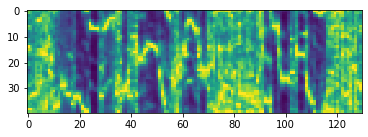

In [9]:
y = librosa.core.load(r'emotion\meld\val\happy\MEL_dia112_utt11_positive_HAP.wav')[0]
y = librosa.util.fix_length(y, 66150)
S = np.abs(librosa.stft(y))
D_short = librosa.feature.chroma_stft(S=S, n_chroma=40)
plt.imshow(D_short)

In [10]:
D_short = (D_short-D_short.min())/(D_short.max()-D_short.min())
trans = transforms.ToPILImage()
a = trans(D_short)
trans = transforms.Resize((40,140))
a = trans(a)
trans = transforms.ToTensor()
a = trans(a)
a= a.unsqueeze(0)
a.shape

torch.Size([1, 1, 40, 140])

In [11]:
model.eval()
model.load_state_dict(torch.load('MY_MODEL1.pt'))

<All keys matched successfully>

In [11]:
a = a.to(device)
output = model(a)

In [12]:
print(torch.argmax(output))
print(output)

tensor(2, device='cuda:0')
tensor([[-4.4090, -4.0360, 10.0987,  1.0771,  0.6336]], device='cuda:0',
       grad_fn=<AddmmBackward>)
